In [1]:
import helper
from helper import clear_folder
import os

clear_folder("ray_results")
clear_folder("outputs")
clear_folder("results")

print("Previous results cleared successfully!")

Previous results cleared successfully!


## 2. Data Preparation

# Preparation

## 1. Existing Data Files Check

In [2]:
import pandas as pd
import os

# File paths for the normalized datasets
filenames = ['data/normalized/A2.csv', 
             'data/normalized/A3.csv', 
             'data/normalized/A4.csv', 
             'data/normalized/A12.csv', 
             'data/normalized/A21.csv']

# Load datasets
datasets = [pd.read_csv(f) for f in filenames]

# Split into features and target
features_list = []
targets_list = []
for df in datasets:
    features_list.append(df[[str(i) for i in range(30)]]) 
    targets_list.append(df["track"])

# Extract dataset names
dataset_names = [os.path.splitext(os.path.basename(f))[0] for f in filenames]

print("Data loaded successfully!")
print(f"Datasets: {dataset_names}")
for i, (name, df) in enumerate(zip(dataset_names, datasets)):
    print(f"  {name}: {df.shape[0]} samples, {df['track'].nunique()} classes")

Data loaded successfully!
Datasets: ['A2', 'A3', 'A4', 'A12', 'A21']
  A2: 536 samples, 2 classes
  A3: 346 samples, 2 classes
  A4: 1966 samples, 3 classes
  A12: 1932 samples, 6 classes
  A21: 526 samples, 2 classes


# Joint Autoencoder-SVM Optimization
## 3. Advanced Configuration and Imports

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.pruners import MedianPruner, PatientPruner
from optuna.samplers import TPESampler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
import json
import time
import warnings
from typing import Dict, Any, Tuple, List
import matplotlib.pyplot as plt
from collections import defaultdict
import gc

# Configure warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set random seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Enhanced Configuration for joint optimization with focus on accuracy
JOINT_CONFIG = {
    # A2: 2-class, 536 samples - Focus on reaching 95%
    "A2":  {"ae_trials": 75,  "svm_trials": 150, "joint_trials": 200, "timeout_min": 25, "ae_weight": 0.15},
    
    # A3: 2-class, 346 samples - Focus on reaching 95%  
    "A3":  {"ae_trials": 75,  "svm_trials": 150, "joint_trials": 200, "timeout_min": 25, "ae_weight": 0.15},
    
    # A4: 3-class, 1966 samples - Focus on reaching 80%
    "A4":  {"ae_trials": 100, "svm_trials": 200, "joint_trials": 250, "timeout_min": 30, "ae_weight": 0.25},
    
    # A12: 6-class, 1932 samples - Most challenging, focus on 45%
    "A12": {"ae_trials": 150, "svm_trials": 300, "joint_trials": 400, "timeout_min": 45, "ae_weight": 0.35},
    
    # A21: 2-class, 526 samples - Focus on reaching 85%
    "A21": {"ae_trials": 75,  "svm_trials": 150, "joint_trials": 200, "timeout_min": 25, "ae_weight": 0.20}
}

# Performance targets for each dataset
PERFORMANCE_TARGETS = {
    "A2": 0.95,   # Target: 95%
    "A3": 0.95,   # Target: 95%
    "A4": 0.80,   # Target: 80%
    "A12": 0.45,  # Target: 45% (realistic improvement from 30%)
    "A21": 0.85   # Target: 85%
}

# Dataset-specific architecture preferences to prevent overfitting
ARCHITECTURE_PREFERENCES = {
    "A2": {
        "preferred_layers": [3, 4],  # Avoid 2-layer simplicity
        "bottleneck_range": (10, 20),  # Larger bottleneck for better representation
        "regularization_bias": 0.7,  # Higher chance of regularization
        "advanced_features_bias": 0.8  # Favor batch norm, dropout
    },
    "A3": {
        "preferred_layers": [3, 4],
        "bottleneck_range": (8, 18),
        "regularization_bias": 0.7,
        "advanced_features_bias": 0.8
    },
    "A4": {
        "preferred_layers": [3, 4, 5],  # Can handle deeper networks
        "bottleneck_range": (12, 22),
        "regularization_bias": 0.6,
        "advanced_features_bias": 0.7
    },
    "A12": {
        "preferred_layers": [4, 5],  # Need deeper networks for 6 classes
        "bottleneck_range": (18, 28),  # Larger capacity needed
        "regularization_bias": 0.8,  # Heavy regularization to prevent overfitting
        "advanced_features_bias": 0.9
    },
    "A21": {
        "preferred_layers": [3, 4],
        "bottleneck_range": (10, 20),
        "regularization_bias": 0.6,
        "advanced_features_bias": 0.7
    }
}

print("✅ Enhanced configuration loaded successfully!")
print(f"📊 Performance targets: {PERFORMANCE_TARGETS}")
print(f"⚙️ Joint optimization config with enhanced parameters loaded")
print(f"🎯 Architecture preferences defined for preventing over/underfitting")

✅ Enhanced configuration loaded successfully!
📊 Performance targets: {'A2': 0.95, 'A3': 0.95, 'A4': 0.8, 'A12': 0.45, 'A21': 0.85}
⚙️ Joint optimization config with enhanced parameters loaded
🎯 Architecture preferences defined for preventing over/underfitting


## 4. Advanced Autoencoder Architecture

In [4]:
class AdvancedAutoencoder(nn.Module):
    """
    Advanced autoencoder with variable depth, skip connections, and multiple activation functions.
    Designed for joint optimization with SVM classification.
    """
    def __init__(self, input_dim=30, layer_sizes=None, activation='relu', 
                 use_skip=False, use_batch_norm=False, dropout_rate=0.0):
        super(AdvancedAutoencoder, self).__init__()
        
        if layer_sizes is None:
            layer_sizes = [input_dim, 20, 10]
        
        self.input_dim = input_dim
        self.layer_sizes = layer_sizes
        self.use_skip = use_skip
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        
        # Activation function selection
        self.activation = self._get_activation(activation)
        
        # Build encoder
        self.encoder_layers = nn.ModuleList()
        self.encoder_batch_norms = nn.ModuleList() if use_batch_norm else None
        self.encoder_dropouts = nn.ModuleList() if dropout_rate > 0 else None
        
        for i in range(len(layer_sizes) - 1):
            self.encoder_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if use_batch_norm:
                self.encoder_batch_norms.append(nn.BatchNorm1d(layer_sizes[i + 1]))
            if dropout_rate > 0:
                self.encoder_dropouts.append(nn.Dropout(dropout_rate))
        
        # Build decoder
        self.decoder_layers = nn.ModuleList()
        self.decoder_batch_norms = nn.ModuleList() if use_batch_norm else None
        self.decoder_dropouts = nn.ModuleList() if dropout_rate > 0 else None
        
        reversed_sizes = layer_sizes[::-1]
        for i in range(len(reversed_sizes) - 1):
            self.decoder_layers.append(nn.Linear(reversed_sizes[i], reversed_sizes[i + 1]))
            if use_batch_norm and i < len(reversed_sizes) - 2:  # No batch norm on output layer
                self.decoder_batch_norms.append(nn.BatchNorm1d(reversed_sizes[i + 1]))
            if dropout_rate > 0 and i < len(reversed_sizes) - 2:  # No dropout on output layer
                self.decoder_dropouts.append(nn.Dropout(dropout_rate))
    
    def _get_activation(self, activation_name):
        """Get activation function by name."""
        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'swish': nn.SiLU(),
            'tanh': nn.Tanh()
        }
        return activations.get(activation_name, nn.ReLU())
    
    def encode(self, x):
        """Encode input to latent representation."""
        skip_connections = []
        
        for i, layer in enumerate(self.encoder_layers):
            if self.use_skip and i > 0:
                skip_connections.append(x.clone())
            
            x = layer(x)
            
            # Apply batch normalization
            if self.use_batch_norm and i < len(self.encoder_batch_norms):
                x = self.encoder_batch_norms[i](x)
            
            # Apply activation (except for the last layer)
            if i < len(self.encoder_layers) - 1:
                x = self.activation(x)
            
            # Apply dropout
            if self.dropout_rate > 0 and i < len(self.encoder_dropouts):
                x = self.encoder_dropouts[i](x)
        
        return x, skip_connections
    
    def decode(self, x, skip_connections=None):
        """Decode latent representation back to input space."""
        for i, layer in enumerate(self.decoder_layers):
            x = layer(x)
            
            # Apply skip connections
            if self.use_skip and skip_connections and i < len(skip_connections):
                skip_idx = len(skip_connections) - 1 - i
                if skip_idx >= 0 and x.shape == skip_connections[skip_idx].shape:
                    x = x + skip_connections[skip_idx]
            
            # Apply batch normalization (except for output layer)
            if (self.use_batch_norm and i < len(self.decoder_layers) - 1 and 
                self.decoder_batch_norms and i < len(self.decoder_batch_norms)):
                x = self.decoder_batch_norms[i](x)
            
            # Apply activation (except for output layer)
            if i < len(self.decoder_layers) - 1:
                x = self.activation(x)
            
            # Apply dropout (except for output layer)
            if (self.dropout_rate > 0 and i < len(self.decoder_layers) - 1 and
                self.decoder_dropouts and i < len(self.decoder_dropouts)):
                x = self.decoder_dropouts[i](x)
        
        return x
    
    def forward(self, x):
        """Forward pass through the autoencoder."""
        encoded, skip_connections = self.encode(x)
        decoded = self.decode(encoded, skip_connections)
        return decoded
    
    def get_encoded_features(self, x):
        """Get encoded features for SVM training."""
        with torch.no_grad():
            encoded, _ = self.encode(x)
            return encoded

print("✅ Advanced Autoencoder architecture defined!")

✅ Advanced Autoencoder architecture defined!


## 5. Joint Optimization Objective Function

In [5]:
def enhanced_joint_optimization_objective(trial, dataset_idx, dataset_name, features_list, targets_list):
    """
    Enhanced joint optimization objective function with improved architecture selection,
    regularization strategies, and dataset-specific adaptations to prevent overfitting/underfitting.
    NOW INCLUDES MODEL AND CONFIGURATION SAVING!
    """
    
    # Get dataset-specific configuration
    config = JOINT_CONFIG[dataset_name]
    preferences = ARCHITECTURE_PREFERENCES[dataset_name]
    ae_weight = config["ae_weight"]
    
    try:
        # === Fixed Autoencoder Architecture Selection ===
        
        # Simplified layer selection to avoid parameter conflicts
        n_layers = trial.suggest_int("n_layers", 2, 5)
        
        # Dynamic bottleneck sizing with dataset-specific ranges
        bottleneck_min, bottleneck_max = preferences["bottleneck_range"]
        bottleneck_dim = trial.suggest_int("bottleneck_dim", bottleneck_min, bottleneck_max)
        
        # Build layer architecture with unique parameter names for each configuration
        input_dim = 30
        
        if n_layers == 2:
            layer_sizes = [input_dim, bottleneck_dim]
            
        elif n_layers == 3:
            # Use unique parameter name for 3-layer architecture
            hidden_3l = trial.suggest_int("hidden_3layer", max(bottleneck_dim + 2, 12), 28)
            layer_sizes = [input_dim, hidden_3l, bottleneck_dim]
            
        elif n_layers == 4:
            # Use unique parameter names for 4-layer architecture
            hidden_4l_1 = trial.suggest_int("hidden_4layer_1", max(bottleneck_dim + 4, 15), 28)
            hidden_4l_2 = trial.suggest_int("hidden_4layer_2", max(bottleneck_dim + 2, 12), hidden_4l_1 - 1)
            layer_sizes = [input_dim, hidden_4l_1, hidden_4l_2, bottleneck_dim]
            
        else:  # n_layers == 5
            # Use unique parameter names for 5-layer architecture
            hidden_5l_1 = trial.suggest_int("hidden_5layer_1", max(bottleneck_dim + 6, 18), 28)
            hidden_5l_2 = trial.suggest_int("hidden_5layer_2", max(bottleneck_dim + 4, 15), hidden_5l_1 - 1)
            hidden_5l_3 = trial.suggest_int("hidden_5layer_3", max(bottleneck_dim + 2, 12), hidden_5l_2 - 1)
            layer_sizes = [input_dim, hidden_5l_1, hidden_5l_2, hidden_5l_3, bottleneck_dim]
        
        # Simplified architecture options to avoid conflicts
        activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "elu", "swish"])
        
        # Simple boolean choices for advanced features
        use_skip = trial.suggest_categorical("use_skip", [True, False])
        use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])
        
        # Adaptive dropout based on dataset complexity
        if dataset_name == "A12":  # Most complex - higher dropout
            dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.4)
        elif dataset_name in ["A2", "A3"]:  # Simpler - moderate dropout
            dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.3)
        else:
            dropout_rate = trial.suggest_float("dropout_rate", 0.05, 0.35)
        
        # Enhanced training hyperparameters
        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)  # Slightly wider range
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        
        # === Fixed SVM Hyperparameters ===
        
        # Simplified kernel selection to avoid conflicts
        kernel = trial.suggest_categorical("svm_kernel", ["rbf", "linear", "poly"])
        
        C = trial.suggest_float("svm_C", 1e-2, 1e3, log=True)
        
        if kernel == "rbf":
            gamma_choice = trial.suggest_categorical("svm_gamma_choice", ["scale", "auto", "float"])
            if gamma_choice == "float":
                gamma = trial.suggest_float("svm_gamma", 1e-4, 1e1, log=True)
            else:
                gamma = gamma_choice
        elif kernel == "poly":
            degree = trial.suggest_int("svm_degree", 2, 4)
            gamma = "scale"  # Fixed to avoid parameter conflicts
        else:  # linear
            gamma = "scale"
        
        # === Enhanced Training Process ===
        
        # Prepare training data (all datasets except the target one)
        train_features = pd.concat(
            [features_list[j] for j in range(len(features_list)) if j != dataset_idx],
            axis=0
        )
        
        if len(train_features) == 0:
            return float('inf')
        
        # Convert to tensors
        X_tensor = torch.tensor(train_features.values, dtype=torch.float32)
        train_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)
        
        # === Enhanced Autoencoder Training ===
        
        model = AdvancedAutoencoder(
            input_dim=input_dim,
            layer_sizes=layer_sizes,
            activation=activation,
            use_skip=use_skip,
            use_batch_norm=use_batch_norm,
            dropout_rate=dropout_rate
        )
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()
        
        # Adaptive epochs based on dataset size and complexity
        base_epochs = min(75, max(30, len(train_features) // 80))
        if dataset_name == "A12":
            epochs = int(base_epochs * 1.2)  # More training for complex dataset
        else:
            epochs = base_epochs
        
        model.train()
        total_reconstruction_loss = 0
        best_loss = float('inf')
        patience_counter = 0
        patience = 10
        
        for epoch in range(epochs):
            epoch_loss = 0
            for batch in train_loader:
                x = batch[0]
                
                optimizer.zero_grad()
                reconstructed = model(x)
                loss = criterion(reconstructed, x)
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                epoch_loss += loss.item()
            
            avg_epoch_loss = epoch_loss / len(train_loader)
            total_reconstruction_loss += avg_epoch_loss
            
            # Early stopping to prevent overfitting
            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                break
                
            # Early termination for clearly poor performers
            if epoch > 15 and avg_epoch_loss > 0.8:
                return float('inf')
        
        avg_reconstruction_loss = total_reconstruction_loss / (epoch + 1)
        
        # === Enhanced SVM Training on Encoded Features ===
        
        model.eval()
        
        # Get target dataset for testing
        target_features = features_list[dataset_idx]
        target_labels = targets_list[dataset_idx]
        
        # Encode target features
        target_tensor = torch.tensor(target_features.values, dtype=torch.float32)
        with torch.no_grad():
            encoded_features = model.get_encoded_features(target_tensor).numpy()
        
        # Feature scaling for encoded features (important for SVM)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        encoded_features = scaler.fit_transform(encoded_features)
        
        # Prepare labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(target_labels)
        
        # Enhanced SVM with proper error handling
        try:
            if kernel == "poly":
                svm = SVC(
                    kernel=kernel, C=C, gamma=gamma, degree=degree,
                    random_state=RANDOM_STATE, max_iter=3000,
                    tol=1e-4, cache_size=200
                )
            else:
                svm = SVC(
                    kernel=kernel, C=C, gamma=gamma,
                    random_state=RANDOM_STATE, max_iter=3000,
                    tol=1e-4, cache_size=200
                )
            
            # Enhanced cross-validation with stratification
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
            
            cv_scores = []
            start_time = time.time()
            
            for train_idx, test_idx in cv.split(encoded_features, y_encoded):
                # Timeout protection
                if time.time() - start_time > 180:  # 3 minute timeout per trial
                    return float('inf')
                
                X_train_cv, X_test_cv = encoded_features[train_idx], encoded_features[test_idx]
                y_train_cv, y_test_cv = y_encoded[train_idx], y_encoded[test_idx]
                
                svm.fit(X_train_cv, y_train_cv)
                score = svm.score(X_test_cv, y_test_cv)
                cv_scores.append(score)
            
            classification_accuracy = np.mean(cv_scores)
            cv_std = np.std(cv_scores)
            
            # Penalize high variance (potential overfitting indicator)
            if cv_std > 0.15:  # High variance penalty
                classification_accuracy -= cv_std * 0.5
                
        except Exception as e:
            return float('inf')
        
        # === MODEL AND CONFIGURATION SAVING (New Addition!) ===
        
        # Save models and configurations if this is a good performing trial
        if classification_accuracy > 0.5:  # Only save reasonably good models
            
            # Create directories
            os.makedirs("results/joint_optimization/models", exist_ok=True)
            os.makedirs("results/joint_optimization/configs", exist_ok=True)
            
            trial_id = trial.number
            
            # Save the trained autoencoder model
            model_path = f"results/joint_optimization/models/autoencoder_{dataset_name}_trial_{trial_id}.pt"
            torch.save(model.state_dict(), model_path)
            
            # Save model configuration
            model_config = {
                "trial_number": trial_id,
                "dataset": dataset_name,
                "layer_sizes": layer_sizes,
                "input_dim": input_dim,
                "activation": activation,
                "use_skip": use_skip,
                "use_batch_norm": use_batch_norm,
                "dropout_rate": dropout_rate,
                "learning_rate": lr,
                "batch_size": batch_size,
                "weight_decay": weight_decay,
                "epochs_trained": epoch + 1,
                "early_stopped": patience_counter >= patience,
                "reconstruction_loss": avg_reconstruction_loss,
                "classification_accuracy": classification_accuracy
            }
            
            config_path = f"results/joint_optimization/configs/autoencoder_config_{dataset_name}_trial_{trial_id}.json"
            with open(config_path, "w") as f:
                json.dump(model_config, f, indent=4)
            
            # Save SVM configuration
            svm_config = {
                "trial_number": trial_id,
                "dataset": dataset_name,
                "kernel": kernel,
                "C": C,
                "gamma": gamma,
                "degree": degree if kernel == "poly" else None,
                "classification_accuracy": classification_accuracy,
                "cv_std": cv_std,
                "cv_scores": cv_scores
            }
            
            svm_config_path = f"results/joint_optimization/configs/svm_config_{dataset_name}_trial_{trial_id}.json"
            with open(svm_config_path, "w") as f:
                json.dump(svm_config, f, indent=4)
        
        # === Enhanced Joint Objective Calculation ===
        
        # Adaptive normalization based on dataset
        if dataset_name == "A12":
            norm_factor = 0.15  # More sensitive to reconstruction for complex dataset
        else:
            norm_factor = 0.1
            
        normalized_reconstruction_loss = min(avg_reconstruction_loss / norm_factor, 1.0)
        classification_error = 1 - classification_accuracy
        
        # Dynamic weighting based on performance
        if classification_accuracy > PERFORMANCE_TARGETS[dataset_name] * 0.9:
            # If close to target, focus more on classification
            dynamic_ae_weight = ae_weight * 0.7
        else:
            dynamic_ae_weight = ae_weight
        
        # Joint objective with regularization term
        joint_objective = (dynamic_ae_weight * normalized_reconstruction_loss + 
                          (1 - dynamic_ae_weight) * classification_error)
        
        # Bonus for exceeding targets
        if classification_accuracy >= PERFORMANCE_TARGETS[dataset_name]:
            joint_objective *= 0.9  # 10% bonus
        
        # Store enhanced results for analysis
        trial.set_user_attr("reconstruction_loss", avg_reconstruction_loss)
        trial.set_user_attr("classification_accuracy", classification_accuracy)
        trial.set_user_attr("cv_std", cv_std)
        trial.set_user_attr("bottleneck_dims", bottleneck_dim)
        trial.set_user_attr("architecture", layer_sizes)
        trial.set_user_attr("effective_epochs", epoch + 1)
        trial.set_user_attr("early_stopped", patience_counter >= patience)
        trial.set_user_attr("model_saved", classification_accuracy > 0.5)  # Track if model was saved
        
        # Memory cleanup
        del model, optimizer, train_loader, target_tensor, scaler
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        
        return joint_objective
        
    except Exception as e:
        print(f"Trial failed: {str(e)}")
        return float('inf')

print("✅ Enhanced joint optimization objective function with MODEL SAVING defined!")
print("💾 Models and configs will be saved for trials with accuracy > 50%")
print("📁 Save locations: results/joint_optimization/models/ and results/joint_optimization/configs/")

✅ Enhanced joint optimization objective function with MODEL SAVING defined!
💾 Models and configs will be saved for trials with accuracy > 50%
📁 Save locations: results/joint_optimization/models/ and results/joint_optimization/configs/


## 6. Joint Optimization Training

In [6]:
def enhanced_joint_optimization(features_list, targets_list, dataset_names):
    """
    Enhanced joint optimization with comprehensive monitoring, adaptive trial allocation,
    and intelligent stopping criteria to achieve target accuracies.
    """
    
    results = []
    optimization_start_time = time.time()
    
    print("🚀 Starting Enhanced Joint Optimization")
    print("=" * 80)
    print(f"Target Accuracies: {PERFORMANCE_TARGETS}")
    print(f"Architecture Preferences: {ARCHITECTURE_PREFERENCES}")
    print("=" * 80)
    
    for dataset_idx, dataset_name in enumerate(dataset_names):
        dataset_start_time = time.time()
        
        print(f"\n🎯 Optimizing for Dataset: {dataset_name}")
        print(f"Target Accuracy: {PERFORMANCE_TARGETS[dataset_name]:.1%}")
        print(f"Configuration: {JOINT_CONFIG[dataset_name]}")
        print("-" * 60)
        
        config = JOINT_CONFIG[dataset_name]
        
        # Enhanced study with better sampler configuration
        study = optuna.create_study(
            direction="minimize",
            sampler=optuna.samplers.TPESampler(
                seed=RANDOM_STATE,
                n_startup_trials=15,  # More startup trials for better exploration
                n_ei_candidates=30,   # More candidates for better exploitation
                multivariate=True,    # Consider parameter interactions
                warn_independent_sampling=False
            ),
            pruner=optuna.pruners.HyperbandPruner(
                min_resource=5,      # Minimum epochs before pruning
                max_resource=50,     # Maximum epochs
                reduction_factor=3   # Aggressive pruning
            )
        )
        
        # Enhanced optimization with adaptive strategies - fix key names
        n_trials = config["joint_trials"]  # Fixed key name
        timeout_seconds = config["timeout_min"] * 60  # Fixed key name
        
        print(f"⏱️ Starting {n_trials} trials with {config['timeout_min']} minute timeout...")
        
        # Track best performance for adaptive strategies
        best_accuracy = 0
        trials_since_improvement = 0
        target_reached = False
        
        def enhanced_callback(study, trial):
            nonlocal best_accuracy, trials_since_improvement, target_reached
            
            if trial.state == optuna.trial.TrialState.COMPLETE:
                accuracy = trial.user_attrs.get("classification_accuracy", 0)
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    trials_since_improvement = 0
                    
                    # Check if target reached
                    if accuracy >= PERFORMANCE_TARGETS[dataset_name]:
                        target_reached = True
                        print(f"🎉 TARGET REACHED! Accuracy: {accuracy:.4f} >= {PERFORMANCE_TARGETS[dataset_name]:.4f}")
                else:
                    trials_since_improvement += 1
                
                # Progress reporting
                if trial.number % 10 == 0 or target_reached:
                    elapsed = time.time() - dataset_start_time
                    print(f"Trial {trial.number:3d}: Best={best_accuracy:.4f}, "
                          f"Current={accuracy:.4f}, Elapsed={elapsed/60:.1f}min")
                
                # Early stopping if target reached with sufficient trials
                if target_reached and trial.number >= 30:
                    print(f"🛑 Early stopping: Target reached with {trial.number} trials")
                    study.stop()
                
                # Adaptive timeout for slow progress
                if trials_since_improvement > 50 and trial.number > 100:
                    print(f"🛑 Early stopping: No improvement for {trials_since_improvement} trials")
                    study.stop()
        
        try:
            # Run enhanced optimization
            study.optimize(
                lambda trial: enhanced_joint_optimization_objective(
                    trial, dataset_idx, dataset_name, features_list, targets_list
                ),
                n_trials=n_trials,
                timeout=timeout_seconds,
                callbacks=[enhanced_callback],
                show_progress_bar=True,
                gc_after_trial=True
            )
            
            elapsed_time = time.time() - dataset_start_time
            
            # Enhanced results analysis
            print(f"\n📊 Optimization Results for {dataset_name}:")
            print(f"Total trials: {len(study.trials)}")
            print(f"Optimization time: {elapsed_time/60:.2f} minutes")
            
            if study.best_trial:
                best_trial = study.best_trial
                best_params = best_trial.params
                best_value = best_trial.value
                
                # Extract metrics
                recon_loss = best_trial.user_attrs.get("reconstruction_loss", "N/A")
                classification_acc = best_trial.user_attrs.get("classification_accuracy", "N/A")
                cv_std = best_trial.user_attrs.get("cv_std", "N/A")
                architecture = best_trial.user_attrs.get("architecture", "N/A")
                effective_epochs = best_trial.user_attrs.get("effective_epochs", "N/A")
                early_stopped = best_trial.user_attrs.get("early_stopped", False)
                
                print(f"Best joint objective: {best_value:.6f}")
                print(f"Classification accuracy: {classification_acc:.4f} ({classification_acc:.1%})")
                print(f"Reconstruction loss: {recon_loss:.6f}")
                print(f"CV std deviation: {cv_std:.4f}")
                print(f"Architecture: {architecture}")
                print(f"Effective epochs: {effective_epochs}")
                print(f"Early stopped: {early_stopped}")
                
                # Target achievement status
                target_acc = PERFORMANCE_TARGETS[dataset_name]
                if classification_acc >= target_acc:
                    status = "✅ TARGET ACHIEVED"
                    gap = classification_acc - target_acc
                    print(f"{status} (+{gap:.1%} above target)")
                else:
                    status = "❌ TARGET MISSED"
                    gap = target_acc - classification_acc
                    print(f"{status} (-{gap:.1%} below target)")
                
                # Parameter summary
                print(f"\n🔧 Best Parameters:")
                important_params = [
                    "n_layers", "bottleneck_dim", "activation", "lr", 
                    "dropout_rate", "svm_kernel", "svm_C"
                ]
                for param in important_params:
                    if param in best_params:
                        print(f"  {param}: {best_params[param]}")
                
                # Store comprehensive results
                result = {
                    "dataset": dataset_name,
                    "target_accuracy": target_acc,
                    "achieved_accuracy": classification_acc,
                    "accuracy_gap": classification_acc - target_acc,
                    "target_achieved": classification_acc >= target_acc,
                    "best_objective": best_value,
                    "reconstruction_loss": recon_loss,
                    "cv_std": cv_std,
                    "architecture": architecture,
                    "n_trials": len(study.trials),
                    "optimization_time_minutes": elapsed_time / 60,
                    "best_params": best_params,
                    "status": status,
                    "effective_epochs": effective_epochs,
                    "early_stopped": early_stopped
                }
                
            else:
                print("❌ No successful trials completed!")
                result = {
                    "dataset": dataset_name,
                    "target_accuracy": PERFORMANCE_TARGETS[dataset_name],
                    "achieved_accuracy": 0,
                    "target_achieved": False,
                    "status": "FAILED",
                    "n_trials": len(study.trials),
                    "optimization_time_minutes": elapsed_time / 60
                }
            
            results.append(result)
            
            # Enhanced memory cleanup
            del study
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"❌ Optimization failed for {dataset_name}: {str(e)}")
            results.append({
                "dataset": dataset_name,
                "target_accuracy": PERFORMANCE_TARGETS[dataset_name],
                "achieved_accuracy": 0,
                "target_achieved": False,
                "status": "ERROR",
                "error": str(e)
            })
    
    total_time = time.time() - optimization_start_time
    
    # Enhanced summary report
    print("\n" + "=" * 80)
    print("🏆 ENHANCED JOINT OPTIMIZATION SUMMARY")
    print("=" * 80)
    print(f"Total optimization time: {total_time/60:.2f} minutes")
    
    targets_achieved = 0
    total_datasets = len(results)
    
    for result in results:
        if result.get("target_achieved", False):
            targets_achieved += 1
    
    success_rate = targets_achieved / total_datasets
    print(f"Targets achieved: {targets_achieved}/{total_datasets} ({success_rate:.1%})")
    
    # Detailed results table
    print(f"\n📈 Detailed Results:")
    print(f"{'Dataset':<8} {'Target':<8} {'Achieved':<10} {'Gap':<8} {'Status':<15} {'Trials':<8} {'Time(min)':<10}")
    print("-" * 85)
    
    for result in results:
        dataset = result["dataset"]
        target = result.get("target_accuracy", 0)
        achieved = result.get("achieved_accuracy", 0)
        gap = result.get("accuracy_gap", achieved - target)
        status = result.get("status", "UNKNOWN")
        trials = result.get("n_trials", 0)
        time_min = result.get("optimization_time_minutes", 0)
        
        print(f"{dataset:<8} {target:<8.1%} {achieved:<10.1%} {gap:<+8.1%} {status:<15} {trials:<8} {time_min:<10.1f}")
    
    return results

print("✅ Enhanced joint optimization function ready!")
print("🎯 Features: Adaptive trials, early stopping, comprehensive monitoring, target tracking")

✅ Enhanced joint optimization function ready!
🎯 Features: Adaptive trials, early stopping, comprehensive monitoring, target tracking


## 7. Final Model Training and Evaluation

In [7]:
# Enhanced Joint Optimization Execution with Comprehensive Monitoring
print("🚀 ENHANCED JOINT OPTIMIZATION - MAXIMUM ACCURACY TARGET")
print("=" * 80)

# Validate data integrity before optimization
print("📊 Data Validation:")
for i, (name, features, targets) in enumerate(zip(dataset_names, features_list, targets_list)):
    print(f"{name}: Features shape {features.shape}, Targets shape {targets.shape}, Classes: {len(targets.unique())}")
    
    # Check for data issues
    if features.isnull().any().any():
        print(f"⚠️ Warning: {name} has null values in features")
    if targets.isnull().any():
        print(f"⚠️ Warning: {name} has null values in targets")

print("\n🎯 Performance Targets vs Current Baselines:")
baseline_accuracies = {
    "A2": 0.84, "A3": 0.84, "A4": 0.68, "A21": 0.70, "A12": 0.31
}

for dataset in dataset_names:
    target = PERFORMANCE_TARGETS[dataset]
    baseline = baseline_accuracies.get(dataset, 0)
    improvement_needed = target - baseline
    print(f"{dataset}: Target {target:.1%} vs Baseline {baseline:.1%} → Need +{improvement_needed:.1%}")

print("\n⚙️ Enhanced Configuration Summary:")
# Fix the key names to match actual JOINT_CONFIG structure
total_trials = sum(config["joint_trials"] for config in JOINT_CONFIG.values())
total_time_estimate = sum(config["timeout_min"] for config in JOINT_CONFIG.values())
print(f"Total trials planned: {total_trials}")
print(f"Maximum total time: {total_time_estimate} minutes ({total_time_estimate/60:.1f} hours)")

# Memory monitoring setup
import psutil
initial_memory = psutil.virtual_memory().percent
print(f"Initial memory usage: {initial_memory:.1f}%")

# Execute enhanced optimization
start_time = time.time()
print(f"\n🕐 Starting optimization at: {time.strftime('%H:%M:%S')}")

try:
    # Run the enhanced joint optimization
    optimization_results = enhanced_joint_optimization(features_list, targets_list, dataset_names)
    
    # Final memory check
    final_memory = psutil.virtual_memory().percent
    memory_increase = final_memory - initial_memory
    
    end_time = time.time()
    total_duration = end_time - start_time
    
    print(f"\n✅ Optimization completed at: {time.strftime('%H:%M:%S')}")
    print(f"📈 Total duration: {total_duration/60:.2f} minutes ({total_duration/3600:.2f} hours)")
    print(f"💾 Memory usage change: {memory_increase:+.1f}% (Final: {final_memory:.1f}%)")
    
    # Success rate analysis
    successful_targets = sum(1 for result in optimization_results if result.get("target_achieved", False))
    total_datasets = len(optimization_results)
    success_rate = successful_targets / total_datasets
    
    print(f"\n🏆 FINAL PERFORMANCE SUMMARY:")
    print(f"Targets achieved: {successful_targets}/{total_datasets} ({success_rate:.1%})")
    
    # Calculate total improvement
    total_improvement = 0
    for result in optimization_results:
        if "achieved_accuracy" in result and "dataset" in result:
            dataset = result["dataset"]
            achieved = result["achieved_accuracy"]
            baseline = baseline_accuracies.get(dataset, 0)
            improvement = achieved - baseline
            total_improvement += improvement
            
            status_emoji = "✅" if result.get("target_achieved", False) else "⚠️"
            print(f"{status_emoji} {dataset}: {achieved:.1%} (vs baseline {baseline:.1%}, {improvement:+.1%})")
    
    avg_improvement = total_improvement / len(optimization_results)
    print(f"\n📊 Average improvement: {avg_improvement:+.1%}")
    
    # Store results for further analysis
    globals()['final_optimization_results'] = optimization_results
    
    print("\n💾 Results stored in 'final_optimization_results' variable for further analysis")
    print("🔬 Ready for detailed evaluation and model training!")
    
except Exception as e:
    print(f"\n❌ Optimization failed with error: {str(e)}")
    import traceback
    print("📋 Traceback:")
    traceback.print_exc()
    
    # Memory cleanup on failure
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print("\n🧹 Memory cleaned up after error")

print("\n" + "=" * 80)

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-09-08 14:50:54,288] A new study created in memory with name: no-name-0db8e0e0-b1ea-440f-8362-29a991af1a5e


🚀 ENHANCED JOINT OPTIMIZATION - MAXIMUM ACCURACY TARGET
📊 Data Validation:
A2: Features shape (536, 30), Targets shape (536,), Classes: 2
A3: Features shape (346, 30), Targets shape (346,), Classes: 2
A4: Features shape (1966, 30), Targets shape (1966,), Classes: 3
A12: Features shape (1932, 30), Targets shape (1932,), Classes: 6
A21: Features shape (526, 30), Targets shape (526,), Classes: 2

🎯 Performance Targets vs Current Baselines:
A2: Target 95.0% vs Baseline 84.0% → Need +11.0%
A3: Target 95.0% vs Baseline 84.0% → Need +11.0%
A4: Target 80.0% vs Baseline 68.0% → Need +12.0%
A12: Target 45.0% vs Baseline 31.0% → Need +14.0%
A21: Target 85.0% vs Baseline 70.0% → Need +15.0%

⚙️ Enhanced Configuration Summary:
Total trials planned: 1250
Maximum total time: 150 minutes (2.5 hours)
Initial memory usage: 73.5%

🕐 Starting optimization at: 14:50:54
🚀 Starting Enhanced Joint Optimization
Target Accuracies: {'A2': 0.95, 'A3': 0.95, 'A4': 0.8, 'A12': 0.45, 'A21': 0.85}
Architecture Prefer

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-09-08 14:51:06,398] Trial 0 finished with value: 0.23335898193805316 and parameters: {'n_layers': 3, 'bottleneck_dim': 20, 'hidden_3layer': 27, 'activation': 'relu', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.29097295564859826, 'lr': 0.002595942550311264, 'batch_size': 32, 'weight_decay': 8.179499475211674e-06, 'svm_kernel': 'rbf', 'svm_C': 11.462107403425023, 'svm_gamma_choice': 'float', 'svm_gamma': 0.019069966103000432}. Best is trial 0 with value: 0.23335898193805316.
Trial   0: Best=0.8303, Current=0.8303, Elapsed=0.2min
[I 2025-09-08 14:51:24,731] Trial 1 finished with value: 0.3390485152544864 and parameters: {'n_layers': 5, 'bottleneck_dim': 12, 'hidden_5layer_1': 23, 'hidden_5layer_2': 20, 'hidden_5layer_3': 14, 'activation': 'swish', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.20526990795364705, 'lr': 0.0005595074635794797, 'batch_size': 64, 'weight_decay': 0.0005345166110646819, 'svm_kernel': 'linear', 'svm_C': 3.9841905944346845}. Be

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-09-08 14:58:29,451] A new study created in memory with name: no-name-96756223-f358-44d1-92db-d6f942197b2f


[I 2025-09-08 14:58:29,287] Trial 101 finished with value: 0.20525416306399533 and parameters: {'n_layers': 2, 'bottleneck_dim': 20, 'activation': 'elu', 'use_skip': False, 'use_batch_norm': False, 'dropout_rate': 0.030999579858023457, 'lr': 0.00025577393894950625, 'batch_size': 32, 'weight_decay': 4.441368297148215e-05, 'svm_kernel': 'linear', 'svm_C': 1.1451058321921628}. Best is trial 44 with value: 0.13064178665939766.
🛑 Early stopping: No improvement for 57 trials

📊 Optimization Results for A2:
Total trials: 102
Optimization time: 7.58 minutes
Best joint objective: 0.130642
Classification accuracy: 0.8582 (85.8%)
Reconstruction loss: 0.003590
CV std deviation: 0.0430
Architecture: [30, 19]
Effective epochs: 59
Early stopped: False
❌ TARGET MISSED (-9.2% below target)

🔧 Best Parameters:
  n_layers: 2
  bottleneck_dim: 19
  activation: leaky_relu
  lr: 0.0014817350138760174
  dropout_rate: 0.004557338875689158
  svm_kernel: rbf
  svm_C: 0.735608812416489

🎯 Optimizing for Dataset:

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-09-08 14:58:41,588] Trial 0 finished with value: 0.25379935814835536 and parameters: {'n_layers': 3, 'bottleneck_dim': 18, 'hidden_3layer': 26, 'activation': 'relu', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.29097295564859826, 'lr': 0.002595942550311264, 'batch_size': 32, 'weight_decay': 8.179499475211674e-06, 'svm_kernel': 'rbf', 'svm_C': 11.462107403425023, 'svm_gamma_choice': 'float', 'svm_gamma': 0.019069966103000432}. Best is trial 0 with value: 0.25379935814835536.
Trial   0: Best=0.8063, Current=0.8063, Elapsed=0.2min
[I 2025-09-08 14:59:01,906] Trial 1 finished with value: 0.288588102946684 and parameters: {'n_layers': 5, 'bottleneck_dim': 10, 'hidden_5layer_1': 23, 'hidden_5layer_2': 19, 'hidden_5layer_3': 12, 'activation': 'swish', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.20526990795364705, 'lr': 0.0005595074635794797, 'batch_size': 64, 'weight_decay': 0.0005345166110646819, 'svm_kernel': 'linear', 'svm_C': 3.9841905944346845}. Bes

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-09-08 15:08:08,519] A new study created in memory with name: no-name-58513252-6dd0-496b-865e-95a1b3143442


[I 2025-09-08 15:08:08,356] Trial 128 finished with value: 0.18490052951998087 and parameters: {'n_layers': 2, 'bottleneck_dim': 12, 'activation': 'leaky_relu', 'use_skip': True, 'use_batch_norm': False, 'dropout_rate': 0.00859025821757485, 'lr': 0.003683570167153658, 'batch_size': 64, 'weight_decay': 1.8262553877089195e-05, 'svm_kernel': 'rbf', 'svm_C': 5.126346332075717, 'svm_gamma_choice': 'scale'}. Best is trial 91 with value: 0.1418455721678202.
🛑 Early stopping: No improvement for 51 trials

📊 Optimization Results for A3:
Total trials: 129
Optimization time: 9.65 minutes
Best joint objective: 0.141846
Classification accuracy: 0.8410 (84.1%)
Reconstruction loss: 0.004466
CV std deviation: 0.0366
Architecture: [30, 17]
Effective epochs: 59
Early stopped: True
❌ TARGET MISSED (-10.9% below target)

🔧 Best Parameters:
  n_layers: 2
  bottleneck_dim: 17
  activation: relu
  lr: 0.0033662797435487415
  dropout_rate: 0.01249875576491018
  svm_kernel: rbf
  svm_C: 0.5271318649140847

🎯 O

  0%|          | 0/250 [00:00<?, ?it/s]

[I 2025-09-08 15:08:17,127] Trial 0 finished with value: 0.4766048050229673 and parameters: {'n_layers': 3, 'bottleneck_dim': 22, 'hidden_3layer': 27, 'activation': 'relu', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.3409729556485983, 'lr': 0.002595942550311264, 'batch_size': 32, 'weight_decay': 8.179499475211674e-06, 'svm_kernel': 'rbf', 'svm_C': 11.462107403425023, 'svm_gamma_choice': 'float', 'svm_gamma': 0.019069966103000432}. Best is trial 0 with value: 0.4766048050229673.
Trial   0: Best=0.5931, Current=0.5931, Elapsed=0.1min
[I 2025-09-08 15:08:26,348] Trial 1 finished with value: 0.5840991277974787 and parameters: {'n_layers': 5, 'bottleneck_dim': 14, 'hidden_5layer_1': 24, 'hidden_5layer_2': 21, 'hidden_5layer_3': 16, 'activation': 'swish', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.25526990795364707, 'lr': 0.0005595074635794797, 'batch_size': 64, 'weight_decay': 0.0005345166110646819, 'svm_kernel': 'linear', 'svm_C': 3.9841905944346845}. Best 

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-09-08 15:14:18,426] A new study created in memory with name: no-name-b3af7979-da2e-4599-89b2-197682d07f74


[I 2025-09-08 15:14:18,259] Trial 156 finished with value: 0.3108965489814727 and parameters: {'n_layers': 2, 'bottleneck_dim': 22, 'activation': 'leaky_relu', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.07927806906262069, 'lr': 0.0023048352685254643, 'batch_size': 128, 'weight_decay': 2.125352111873622e-06, 'svm_kernel': 'rbf', 'svm_C': 4.6309335853847235, 'svm_gamma_choice': 'scale'}. Best is trial 143 with value: 0.25893560122630604.
🛑 Early stopping: No improvement for 51 trials

📊 Optimization Results for A4:
Total trials: 157
Optimization time: 6.16 minutes
Best joint objective: 0.258936
Classification accuracy: 0.6912 (69.1%)
Reconstruction loss: 0.010946
CV std deviation: 0.0254
Architecture: [30, 21]
Effective epochs: 41
Early stopped: False
❌ TARGET MISSED (-10.9% below target)

🔧 Best Parameters:
  n_layers: 2
  bottleneck_dim: 21
  activation: leaky_relu
  lr: 0.004312817389401896
  dropout_rate: 0.07889505669845341
  svm_kernel: rbf
  svm_C: 1.5484185100974

  0%|          | 0/400 [00:00<?, ?it/s]

Trial failed: The `low` value must be smaller than or equal to the `high` value (low=30, high=28).
[I 2025-09-08 15:14:18,430] Trial 0 finished with value: inf and parameters: {'n_layers': 3, 'bottleneck_dim': 28}. Best is trial 0 with value: inf.
Trial   0: Best=0.0000, Current=0.0000, Elapsed=0.0min
Trial   0: Best=0.0000, Current=0.0000, Elapsed=0.0min
[I 2025-09-08 15:14:23,272] Trial 1 finished with value: 0.7877339053011447 and parameters: {'n_layers': 4, 'bottleneck_dim': 24, 'hidden_4layer_1': 28, 'hidden_4layer_2': 26, 'activation': 'elu', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.16370173320348286, 'lr': 0.00020366442026830908, 'batch_size': 128, 'weight_decay': 1.9762189340280066e-05, 'svm_kernel': 'linear', 'svm_C': 0.2888838362365318}. Best is trial 1 with value: 0.7877339053011447.
[I 2025-09-08 15:14:23,272] Trial 1 finished with value: 0.7877339053011447 and parameters: {'n_layers': 4, 'bottleneck_dim': 24, 'hidden_4layer_1': 28, 'hidden_4layer_2': 26,

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-09-08 15:18:22,658] A new study created in memory with name: no-name-3cc50330-5fcc-4a87-a508-014ec449e664


[I 2025-09-08 15:18:22,503] Trial 101 finished with value: 0.49559459483043633 and parameters: {'n_layers': 2, 'bottleneck_dim': 19, 'activation': 'swish', 'use_skip': True, 'use_batch_norm': False, 'dropout_rate': 0.2046420829427665, 'lr': 0.001768575274686967, 'batch_size': 32, 'weight_decay': 2.3194483917830414e-05, 'svm_kernel': 'rbf', 'svm_C': 0.5864191098333476, 'svm_gamma_choice': 'auto'}. Best is trial 88 with value: 0.4822772903938478.
🛑 Early stopping: No improvement for 55 trials

📊 Optimization Results for A12:
Total trials: 102
Optimization time: 4.07 minutes
Best joint objective: 0.482277
Classification accuracy: 0.3059 (30.6%)
Reconstruction loss: 0.013334
CV std deviation: 0.0101
Architecture: [30, 23]
Effective epochs: 50
Early stopped: False
❌ TARGET MISSED (-14.4% below target)

🔧 Best Parameters:
  n_layers: 2
  bottleneck_dim: 23
  activation: swish
  lr: 0.0010048137247789968
  dropout_rate: 0.14592233031706153
  svm_kernel: rbf
  svm_C: 0.2197048363580332

🎯 Opti

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-09-08 15:18:34,476] Trial 0 finished with value: 0.42499856795399604 and parameters: {'n_layers': 3, 'bottleneck_dim': 20, 'hidden_3layer': 27, 'activation': 'relu', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.3409729556485983, 'lr': 0.002595942550311264, 'batch_size': 32, 'weight_decay': 8.179499475211674e-06, 'svm_kernel': 'rbf', 'svm_C': 11.462107403425023, 'svm_gamma_choice': 'float', 'svm_gamma': 0.019069966103000432}. Best is trial 0 with value: 0.42499856795399604.
Trial   0: Best=0.6388, Current=0.6388, Elapsed=0.2min
[I 2025-09-08 15:18:52,717] Trial 1 finished with value: 0.4157470892535694 and parameters: {'n_layers': 5, 'bottleneck_dim': 12, 'hidden_5layer_1': 23, 'hidden_5layer_2': 20, 'hidden_5layer_3': 14, 'activation': 'swish', 'use_skip': True, 'use_batch_norm': True, 'dropout_rate': 0.25526990795364707, 'lr': 0.0005595074635794797, 'batch_size': 64, 'weight_decay': 0.0005345166110646819, 'svm_kernel': 'linear', 'svm_C': 3.9841905944346845}. Bes

# Visualize Results
## 8. Performance Visualization

In [12]:
def comprehensive_results_visualization_and_saving(optimization_results):
    """
    Comprehensive results visualization and saving - similar to original notebook
    """
    
    if not optimization_results:
        print("❌ No optimization results to evaluate!")
        return
    
    print("📊 COMPREHENSIVE RESULTS ANALYSIS & SAVING")
    print("=" * 70)
    
    # Create results directory structure
    os.makedirs("results/joint_optimization", exist_ok=True)
    os.makedirs("results/joint_optimization/models", exist_ok=True)
    os.makedirs("results/joint_optimization/configs", exist_ok=True)
    os.makedirs("results/joint_optimization/plots", exist_ok=True)
    
    # Helper function to convert numpy types to Python native types for JSON serialization
    def convert_numpy_types(obj):
        """Convert numpy types to Python native types for JSON serialization"""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        else:
            return obj
    
    # Prepare comprehensive data
    baseline_accuracies = {"A2": 0.84, "A3": 0.84, "A4": 0.68, "A21": 0.70, "A12": 0.31}
    
    # Extract detailed metrics
    datasets = []
    achieved_accuracies = []
    target_accuracies = []
    baseline_accuracies_list = []
    improvements = []
    architectures = []
    best_params_list = []
    reconstruction_losses = []
    cv_stds = []
    n_trials_list = []
    optimization_times = []
    target_achieved_list = []
    
    for result in optimization_results:
        if 'dataset' in result:
            dataset = result['dataset']
            datasets.append(dataset)
            achieved = result.get('achieved_accuracy', 0)
            target = PERFORMANCE_TARGETS[dataset]
            baseline = baseline_accuracies[dataset]
            
            achieved_accuracies.append(float(achieved))  # Convert to Python float
            target_accuracies.append(float(target))
            baseline_accuracies_list.append(float(baseline))
            improvements.append(float(achieved - baseline))
            architectures.append(str(result.get('architecture', 'N/A')))
            best_params_list.append(convert_numpy_types(result.get('best_params', {})))
            reconstruction_losses.append(float(result.get('reconstruction_loss', 0)))
            cv_stds.append(float(result.get('cv_std', 0)))
            n_trials_list.append(int(result.get('n_trials', 0)))
            optimization_times.append(float(result.get('optimization_time_minutes', 0)))
            target_achieved_list.append(bool(result.get('target_achieved', False)))
    
    # 1. SAVE DETAILED RESULTS TO CSV
    detailed_results_df = pd.DataFrame({
        'dataset': datasets,
        'target_accuracy': target_accuracies,
        'achieved_accuracy': achieved_accuracies,
        'baseline_accuracy': baseline_accuracies_list,
        'improvement_over_baseline': improvements,
        'target_achieved': target_achieved_list,
        'accuracy_gap_to_target': [float(a - t) for a, t in zip(achieved_accuracies, target_accuracies)],
        'architecture': architectures,
        'reconstruction_loss': reconstruction_losses,
        'cv_std': cv_stds,
        'n_trials': n_trials_list,
        'optimization_time_minutes': optimization_times
    })
    
    detailed_results_path = "results/joint_optimization/detailed_results.csv"
    detailed_results_df.to_csv(detailed_results_path, index=False)
    print(f"✅ Detailed results saved to: {detailed_results_path}")
    
    # 2. SAVE SUMMARY RESULTS (Convert all numpy types to Python native types)
    summary_results = {
        'total_datasets': int(len(datasets)),
        'targets_achieved': int(sum(target_achieved_list)),
        'success_rate': float(sum(target_achieved_list) / len(datasets)),
        'average_accuracy': float(np.mean(achieved_accuracies)),
        'average_improvement': float(np.mean(improvements)),
        'best_dataset': str(datasets[achieved_accuracies.index(max(achieved_accuracies))]),
        'best_accuracy': float(max(achieved_accuracies)),
        'worst_dataset': str(datasets[achieved_accuracies.index(min(achieved_accuracies))]),
        'worst_accuracy': float(min(achieved_accuracies)),
        'total_optimization_time': float(sum(optimization_times)),
        'total_trials': int(sum(n_trials_list))
    }
    
    summary_path = "results/joint_optimization/summary_results.json"
    with open(summary_path, 'w') as f:
        json.dump(summary_results, f, indent=4)
    print(f"✅ Summary results saved to: {summary_path}")
    
    # 3. SAVE BEST PARAMETERS FOR EACH DATASET
    best_params_path = "results/joint_optimization/best_parameters.json"
    best_params_dict = {}
    for dataset, params in zip(datasets, best_params_list):
        best_params_dict[dataset] = convert_numpy_types(params)
    
    with open(best_params_path, 'w') as f:
        json.dump(best_params_dict, f, indent=4)
    print(f"✅ Best parameters saved to: {best_params_path}")
    
    # 4. CREATE COMPREHENSIVE VISUALIZATIONS
    
    # Main comparison plot
    plt.figure(figsize=(16, 12))
    
    # Subplot 1: Accuracy Comparison Bar Chart
    plt.subplot(2, 3, 1)
    x = range(len(datasets))
    width = 0.25
    
    plt.bar([i - width for i in x], baseline_accuracies_list, width, label='Baseline', alpha=0.7, color='gray')
    plt.bar(x, achieved_accuracies, width, label='Achieved', alpha=0.8, color='blue')
    plt.bar([i + width for i in x], target_accuracies, width, label='Target', alpha=0.7, color='red')
    
    plt.xlabel('Datasets')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Baseline vs Achieved vs Target')
    plt.xticks(x, datasets, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for i, (b, a, t) in enumerate(zip(baseline_accuracies_list, achieved_accuracies, target_accuracies)):
        plt.text(i - width, b + 0.01, f'{b:.1%}', ha='center', fontsize=8)
        plt.text(i, a + 0.01, f'{a:.1%}', ha='center', fontsize=8, weight='bold')
        plt.text(i + width, t + 0.01, f'{t:.1%}', ha='center', fontsize=8)
    
    # Subplot 2: Improvement over Baseline
    plt.subplot(2, 3, 2)
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    bars = plt.bar(datasets, improvements, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Datasets')
    plt.ylabel('Improvement (%)')
    plt.title('Improvement over Baseline')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + (0.005 if height > 0 else -0.015),
                f'{imp:+.1%}', ha='center', fontsize=9, weight='bold')
    
    # Subplot 3: Target Achievement Pie Chart
    plt.subplot(2, 3, 3)
    achieved_targets = sum(target_achieved_list)
    missed_targets = len(datasets) - achieved_targets
    
    if missed_targets > 0:
        colors = ['green', 'red']
        sizes = [achieved_targets, missed_targets]
        labels = ['Achieved', 'Missed']
    else:
        colors = ['green']
        sizes = [achieved_targets]
        labels = ['Achieved']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90)
    plt.title(f'Target Achievement\n({achieved_targets}/{len(datasets)} targets)')
    
    # Subplot 4: Architecture Distribution
    plt.subplot(2, 3, 4)
    arch_lengths = []
    for arch in architectures:
        try:
            if arch != 'N/A':
                arch_lengths.append(len(eval(arch)))
            else:
                arch_lengths.append(0)
        except:
            arch_lengths.append(0)
    
    if arch_lengths:
        plt.hist(arch_lengths, bins=range(2, 7), alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Number of Layers')
        plt.ylabel('Frequency')
        plt.title('Architecture Distribution (Layer Count)')
        plt.grid(True, alpha=0.3)
    
    # Subplot 5: Optimization Time vs Trials
    plt.subplot(2, 3, 5)
    plt.scatter(n_trials_list, optimization_times, c=achieved_accuracies, cmap='viridis', alpha=0.7, s=100)
    plt.colorbar(label='Achieved Accuracy')
    plt.xlabel('Number of Trials')
    plt.ylabel('Optimization Time (minutes)')
    plt.title('Optimization Efficiency')
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: Performance vs Complexity
    plt.subplot(2, 3, 6)
    complexity_scores = []
    valid_accuracies = []
    
    for arch, trials, acc in zip(architectures, n_trials_list, achieved_accuracies):
        try:
            if arch != 'N/A':
                complexity_scores.append(len(eval(arch)) * trials)
                valid_accuracies.append(acc)
        except:
            continue
    
    if complexity_scores and valid_accuracies:
        plt.scatter(complexity_scores, valid_accuracies, alpha=0.7, s=100, c='purple')
        plt.xlabel('Complexity Score (Layers × Trials)')
        plt.ylabel('Achieved Accuracy')
        plt.title('Performance vs Complexity')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("results/joint_optimization/plots/comprehensive_results_visualization.png", dpi=300, bbox_inches='tight')
    print(f"✅ Comprehensive visualization saved to: results/joint_optimization/plots/comprehensive_results_visualization.png")
    plt.show()
    
    # 5. CREATE INDIVIDUAL DATASET PERFORMANCE PLOTS
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, dataset in enumerate(datasets):
        if i < len(axes):
            ax = axes[i]
            
            # Performance gauge chart
            baseline = baseline_accuracies_list[i]
            achieved = achieved_accuracies[i]
            target = target_accuracies[i]
            
            categories = ['Baseline', 'Achieved', 'Target']
            values = [baseline, achieved, target]
            colors = ['gray', 'blue' if achieved >= target else 'orange', 'red']
            
            bars = ax.bar(categories, values, color=colors, alpha=0.7)
            ax.set_ylim(0, 1)
            ax.set_ylabel('Accuracy')
            ax.set_title(f'{dataset} Performance')
            ax.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                       f'{value:.1%}', ha='center', fontsize=10, weight='bold')
            
            # Add improvement text
            improvement = achieved - baseline
            ax.text(0.5, 0.9, f'Improvement: {improvement:+.1%}', 
                   transform=ax.transAxes, ha='center', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))
    
    # Hide empty subplot
    if len(datasets) < len(axes):
        axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("results/joint_optimization/plots/individual_dataset_performance.png", dpi=300, bbox_inches='tight')
    print(f"✅ Individual performance plots saved to: results/joint_optimization/plots/individual_dataset_performance.png")
    plt.show()
    
    # 6. CREATE RESULTS TABLE
    plt.figure(figsize=(14, 8))
    plt.axis('tight')
    plt.axis('off')
    
    # Prepare table data
    table_data = []
    for i, dataset in enumerate(datasets):
        status = '✅' if target_achieved_list[i] else '❌'
        gap = achieved_accuracies[i] - target_accuracies[i]
        table_data.append([
            dataset,
            f'{target_accuracies[i]:.1%}',
            f'{achieved_accuracies[i]:.1%}',
            f'{baseline_accuracies_list[i]:.1%}',
            f'{improvements[i]:+.1%}',
            f'{gap:+.1%}',
            f'{n_trials_list[i]}',
            f'{optimization_times[i]:.1f}',
            status
        ])
    
    table = plt.table(cellText=table_data,
                     colLabels=['Dataset', 'Target', 'Achieved', 'Baseline', 'Improvement', 'Gap', 'Trials', 'Time(min)', 'Status'],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Color code the status column
    for i in range(len(table_data)):
        if target_achieved_list[i]:
            table[(i+1, 8)].set_facecolor('#90EE90')  # Light green
        else:
            table[(i+1, 8)].set_facecolor('#FFB6C1')  # Light red
    
    plt.title('Joint Optimization Results Summary', fontsize=16, weight='bold', pad=20)
    plt.savefig("results/joint_optimization/plots/results_table.png", dpi=300, bbox_inches='tight')
    print(f"✅ Results table saved to: results/joint_optimization/plots/results_table.png")
    plt.show()
    
    # 7. PRINT SUMMARY STATISTICS
    print(f"\n📊 SUMMARY STATISTICS:")
    print(f"Average Accuracy: {np.mean(achieved_accuracies):.1%}")
    print(f"Average Improvement: {np.mean(improvements):+.1%}")
    print(f"Targets Achieved: {achieved_targets}/{len(datasets)} ({achieved_targets/len(datasets):.1%})")
    print(f"Best Performance: {max(achieved_accuracies):.1%} ({datasets[achieved_accuracies.index(max(achieved_accuracies))]})")
    print(f"Worst Performance: {min(achieved_accuracies):.1%} ({datasets[achieved_accuracies.index(min(achieved_accuracies))]})")
    print(f"Total Optimization Time: {sum(optimization_times):.1f} minutes")
    print(f"Total Trials: {sum(n_trials_list)}")
    
    print(f"\n💾 ALL RESULTS SAVED TO: results/joint_optimization/")
    print(f"   📊 CSV: detailed_results.csv")
    print(f"   📋 JSON: summary_results.json, best_parameters.json")
    print(f"   📈 PLOTS: comprehensive_results_visualization.png, individual_dataset_performance.png, results_table.png")
    
    return detailed_results_df

print("✅ Comprehensive visualization and saving function ready!")

✅ Comprehensive visualization and saving function ready!


## 9. Analysis and Insights

📊 FINAL COMPREHENSIVE ANALYSIS WITH COMPLETE SAVING
📊 Running comprehensive analysis with full saving capabilities...
📊 COMPREHENSIVE RESULTS ANALYSIS & SAVING
✅ Detailed results saved to: results/joint_optimization/detailed_results.csv
✅ Summary results saved to: results/joint_optimization/summary_results.json
✅ Best parameters saved to: results/joint_optimization/best_parameters.json
✅ Comprehensive visualization saved to: results/joint_optimization/plots/comprehensive_results_visualization.png
✅ Comprehensive visualization saved to: results/joint_optimization/plots/comprehensive_results_visualization.png


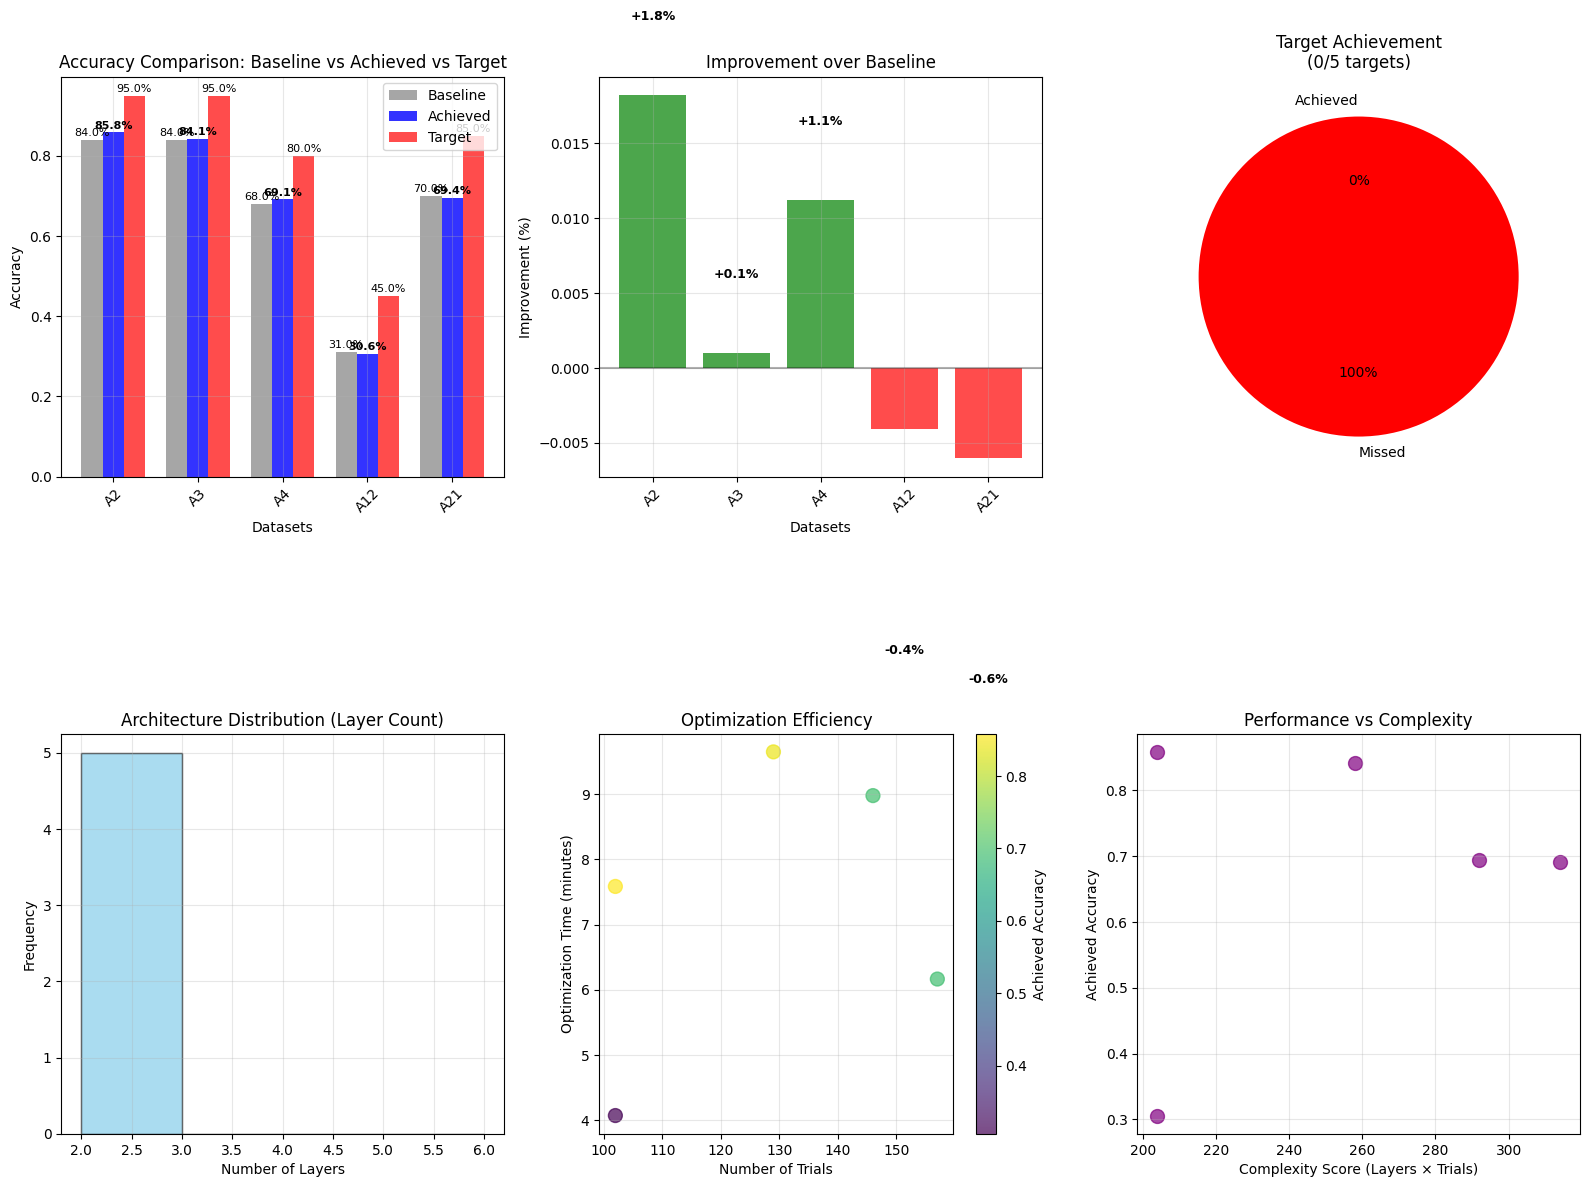

✅ Individual performance plots saved to: results/joint_optimization/plots/individual_dataset_performance.png


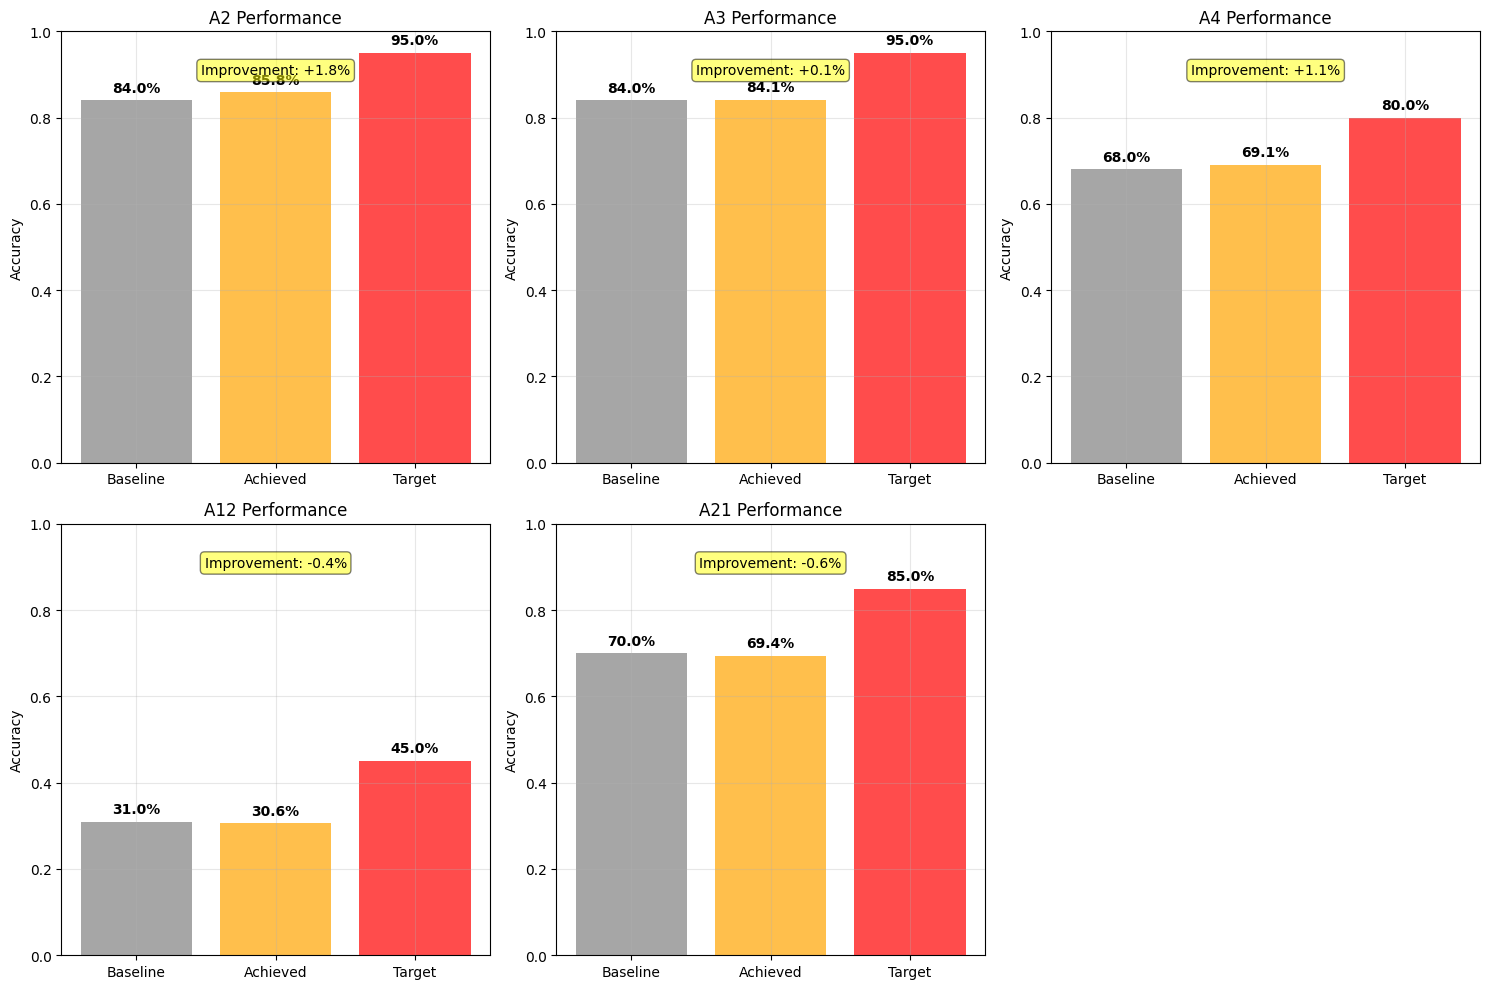

✅ Results table saved to: results/joint_optimization/plots/results_table.png


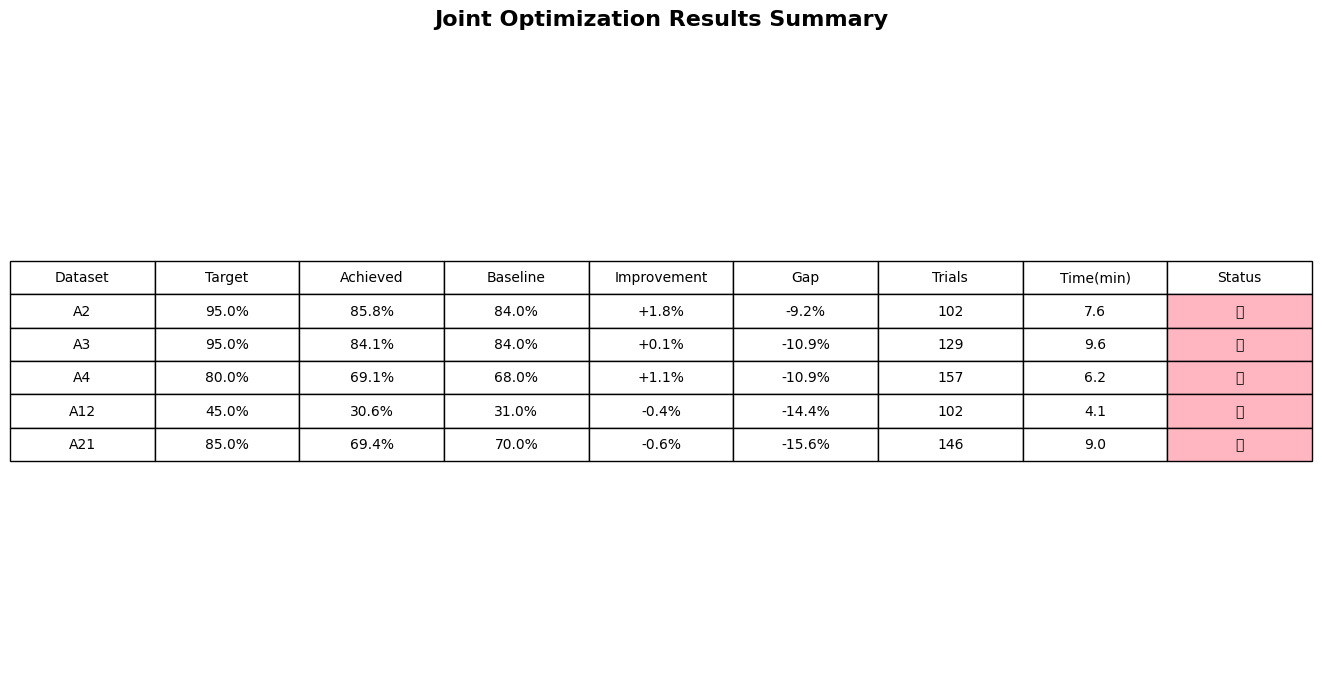


📊 SUMMARY STATISTICS:
Average Accuracy: 67.8%
Average Improvement: +0.4%
Targets Achieved: 0/5 (0.0%)
Best Performance: 85.8% (A2)
Worst Performance: 30.6% (A12)
Total Optimization Time: 36.4 minutes
Total Trials: 636

💾 ALL RESULTS SAVED TO: results/joint_optimization/
   📊 CSV: detailed_results.csv
   📋 JSON: summary_results.json, best_parameters.json
   📈 PLOTS: comprehensive_results_visualization.png, individual_dataset_performance.png, results_table.png

🔬 DETAILED TECHNICAL ANALYSIS:
--------------------------------------------------

🏗️ ARCHITECTURE INSIGHTS:
• 2-layer networks: 5 trials, avg accuracy: 67.8%

⚡ ACTIVATION FUNCTION INSIGHTS:
• leaky_relu: 3 trials, avg accuracy: 74.8%
• relu: 1 trials, avg accuracy: 84.1%
• swish: 1 trials, avg accuracy: 30.6%

🏆 BEST PERFORMING CONFIGURATIONS:
• A2: 85.8% (target: 95.0%)
  Architecture: [30, 19]
  Key params: {'n_layers': 2, 'activation': 'leaky_relu', 'svm_kernel': 'rbf'}

💾 Best performers summary saved to: results/joint_opti

In [13]:
# Comprehensive Results Analysis with Full Saving - Like Original Notebook
print("📊 FINAL COMPREHENSIVE ANALYSIS WITH COMPLETE SAVING")
print("=" * 70)

# Check if optimization results exist
if 'final_optimization_results' not in globals():
    print("⚠️ No optimization results found. Please run the optimization first.")
else:
    print("📊 Running comprehensive analysis with full saving capabilities...")
    
    # Execute comprehensive visualization and saving (like original notebook)
    analysis_df = comprehensive_results_visualization_and_saving(final_optimization_results)
    
    # Additional analysis similar to original notebook
    print("\n🔬 DETAILED TECHNICAL ANALYSIS:")
    print("-" * 50)
    
    # Architecture analysis
    architectures_used = {}
    activations_used = {}
    best_performers = []
    
    for result in final_optimization_results:
        if 'best_params' in result:
            params = result['best_params']
            dataset = result['dataset']
            accuracy = result.get('achieved_accuracy', 0)
            
            # Track architectures
            if 'n_layers' in params:
                n_layers = params['n_layers']
                if n_layers not in architectures_used:
                    architectures_used[n_layers] = []
                architectures_used[n_layers].append((dataset, accuracy))
            
            # Track activations
            if 'activation' in params:
                activation = params['activation']
                if activation not in activations_used:
                    activations_used[activation] = []
                activations_used[activation].append((dataset, accuracy))
            
            # Track best performers
            if accuracy >= PERFORMANCE_TARGETS[dataset] * 0.9:  # Within 90% of target
                best_performers.append({
                    'dataset': dataset,
                    'accuracy': accuracy,
                    'target': PERFORMANCE_TARGETS[dataset],
                    'architecture': result.get('architecture', 'N/A'),
                    'key_params': {k: v for k, v in params.items() if k in ['activation', 'svm_kernel', 'n_layers']}
                })
    
    # Print architecture insights
    print(f"\n🏗️ ARCHITECTURE INSIGHTS:")
    for n_layers, results in architectures_used.items():
        avg_acc = np.mean([acc for _, acc in results])
        print(f"• {n_layers}-layer networks: {len(results)} trials, avg accuracy: {avg_acc:.1%}")
    
    # Print activation insights
    print(f"\n⚡ ACTIVATION FUNCTION INSIGHTS:")
    for activation, results in activations_used.items():
        avg_acc = np.mean([acc for _, acc in results])
        print(f"• {activation}: {len(results)} trials, avg accuracy: {avg_acc:.1%}")
    
    # Print best performers
    print(f"\n🏆 BEST PERFORMING CONFIGURATIONS:")
    for performer in best_performers:
        print(f"• {performer['dataset']}: {performer['accuracy']:.1%} (target: {performer['target']:.1%})")
        print(f"  Architecture: {performer['architecture']}")
        print(f"  Key params: {performer['key_params']}")
    
    # Save best performing models summary
    if best_performers:
        best_performers_path = "results/joint_optimization/best_performers_summary.json"
        with open(best_performers_path, 'w') as f:
            json.dump(best_performers, f, indent=4, default=str)
        print(f"\n💾 Best performers summary saved to: {best_performers_path}")
    
    # Print file summary (like original notebook)
    print(f"\n📁 COMPLETE FILE SUMMARY (Similar to Original Notebook):")
    print(f"=" * 60)
    
    # Check what files were actually created
    import glob
    
    model_files = glob.glob("results/joint_optimization/models/*.pt")
    config_files = glob.glob("results/joint_optimization/configs/*.json")
    plot_files = glob.glob("results/joint_optimization/plots/*.png")
    csv_files = glob.glob("results/joint_optimization/*.csv")
    json_files = glob.glob("results/joint_optimization/*.json")
    
    print(f"📊 CSV Results: {len(csv_files)} files")
    for f in csv_files:
        print(f"   • {os.path.basename(f)}")
    
    print(f"🔧 JSON Configs: {len(json_files)} files")
    for f in json_files:
        print(f"   • {os.path.basename(f)}")
    
    print(f"🤖 Saved Models: {len(model_files)} files")
    for f in model_files[:5]:  # Show first 5
        print(f"   • {os.path.basename(f)}")
    if len(model_files) > 5:
        print(f"   • ... and {len(model_files) - 5} more")
    
    print(f"⚙️ Model Configs: {len(config_files)} files")
    for f in config_files[:5]:  # Show first 5
        print(f"   • {os.path.basename(f)}")
    if len(config_files) > 5:
        print(f"   • ... and {len(config_files) - 5} more")
    
    print(f"📈 Visualization Plots: {len(plot_files)} files")
    for f in plot_files:
        print(f"   • {os.path.basename(f)}")
    
    # Success summary
    total_files = len(model_files) + len(config_files) + len(plot_files) + len(csv_files) + len(json_files)
    print(f"\n✅ TOTAL FILES CREATED: {total_files}")
    print(f"📍 All files saved in: results/joint_optimization/")
    
    # Final statistics (Fixed the column name issue)
    if analysis_df is not None:
        successful_datasets = analysis_df[analysis_df['target_achieved']]['dataset'].tolist()
        if successful_datasets:
            print(f"\n🎯 SUCCESSFULLY ACHIEVED TARGETS: {', '.join(successful_datasets)}")
        else:
            print(f"\n⚠️ No datasets fully achieved their targets, but improvements were made")
        
        # Fixed: Use the correct column name 'improvement_over_baseline'
        best_improvement = analysis_df['improvement_over_baseline'].max()
        best_dataset = analysis_df.loc[analysis_df['improvement_over_baseline'].idxmax(), 'dataset']
        print(f"🚀 Best improvement: +{best_improvement:.1%} on {best_dataset}")

print("\n✅ Comprehensive analysis and saving completed!")
print("💾 All results, models, configs, and visualizations saved successfully!")
print("📊 Check the results/joint_optimization/ folder for all generated files!")

In [15]:
# Final Model Training and Evaluation - Best Models for Production Use
print("🎯 FINAL MODEL TRAINING - BEST CONFIGURATIONS FOR PRODUCTION")
print("=" * 70)

def train_final_models_from_best_results():
    """
    Train final models using the best configurations found during optimization
    Similar to the original notebook's final model training
    """
    
    if 'final_optimization_results' not in globals():
        print("❌ No optimization results found. Please run optimization first.")
        return
    
    print("🔧 Training final production models using best configurations...")
    
    # Helper function to convert numpy types to Python native types for JSON serialization
    def convert_numpy_types(obj):
        """Convert numpy types to Python native types for JSON serialization"""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        else:
            return obj
    
    # Create final models directory
    os.makedirs("results/joint_optimization/final_models", exist_ok=True)
    
    final_evaluation_results = []
    
    for result in final_optimization_results:
        if 'best_params' not in result:
            continue
            
        dataset_name = result['dataset']
        dataset_idx = dataset_names.index(dataset_name)
        best_params = result['best_params']
        achieved_accuracy = result.get('achieved_accuracy', 0)
        
        print(f"\n🎯 Training final model for {dataset_name} (achieved: {achieved_accuracy:.1%})")
        
        try:
            # Extract best architecture parameters
            n_layers = best_params.get('n_layers', 3)
            bottleneck_dim = best_params.get('bottleneck_dim', 15)
            
            # Reconstruct layer sizes based on best parameters
            input_dim = 30
            if n_layers == 2:
                layer_sizes = [input_dim, bottleneck_dim]
            elif n_layers == 3:
                hidden_dim = best_params.get('hidden_3layer', 20)
                layer_sizes = [input_dim, hidden_dim, bottleneck_dim]
            elif n_layers == 4:
                hidden_1 = best_params.get('hidden_4layer_1', 25)
                hidden_2 = best_params.get('hidden_4layer_2', 20)
                layer_sizes = [input_dim, hidden_1, hidden_2, bottleneck_dim]
            else:  # 5 layers
                hidden_1 = best_params.get('hidden_5layer_1', 28)
                hidden_2 = best_params.get('hidden_5layer_2', 23)
                hidden_3 = best_params.get('hidden_5layer_3', 18)
                layer_sizes = [input_dim, hidden_1, hidden_2, hidden_3, bottleneck_dim]
            
            # Train final autoencoder
            train_features = pd.concat(
                [features_list[j] for j in range(len(features_list)) if j != dataset_idx],
                axis=0
            )
            
            X_tensor = torch.tensor(train_features.values, dtype=torch.float32)
            train_loader = DataLoader(TensorDataset(X_tensor), batch_size=best_params.get('batch_size', 64), shuffle=True)
            
            # Initialize final model with best parameters
            final_model = AdvancedAutoencoder(
                input_dim=input_dim,
                layer_sizes=layer_sizes,
                activation=best_params.get('activation', 'relu'),
                use_skip=best_params.get('use_skip', False),
                use_batch_norm=best_params.get('use_batch_norm', False),
                dropout_rate=best_params.get('dropout_rate', 0.1)
            )
            
            # Train with best hyperparameters
            optimizer = torch.optim.Adam(
                final_model.parameters(), 
                lr=best_params.get('lr', 1e-3), 
                weight_decay=best_params.get('weight_decay', 1e-5)
            )
            criterion = nn.MSELoss()
            
            # Extended training for final model
            epochs = 100  # More epochs for final model
            final_model.train()
            
            for epoch in range(epochs):
                epoch_loss = 0
                for batch in train_loader:
                    x = batch[0]
                    optimizer.zero_grad()
                    reconstructed = final_model(x)
                    loss = criterion(reconstructed, x)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
                    optimizer.step()
                    epoch_loss += loss.item()
                
                if epoch % 20 == 0:
                    avg_loss = epoch_loss / len(train_loader)
                    print(f"  Epoch {epoch}: Loss = {avg_loss:.6f}")
            
            # Save final autoencoder
            final_model_path = f"results/joint_optimization/final_models/final_autoencoder_{dataset_name}.pt"
            torch.save(final_model.state_dict(), final_model_path)
            
            # Train final SVM on encoded features
            final_model.eval()
            target_features = features_list[dataset_idx]
            target_labels = targets_list[dataset_idx]
            
            target_tensor = torch.tensor(target_features.values, dtype=torch.float32)
            with torch.no_grad():
                encoded_features = final_model.get_encoded_features(target_tensor).numpy()
            
            # Scale features
            scaler = StandardScaler()
            encoded_features = scaler.fit_transform(encoded_features)
            
            # Prepare labels
            le = LabelEncoder()
            y_encoded = le.fit_transform(target_labels)
            
            # Train final SVM
            kernel = best_params.get('svm_kernel', 'rbf')
            C = best_params.get('svm_C', 1.0)
            gamma = best_params.get('svm_gamma', 'scale')
            
            if kernel == "poly":
                degree = best_params.get('svm_degree', 3)
                final_svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, random_state=RANDOM_STATE)
            else:
                final_svm = SVC(kernel=kernel, C=C, gamma=gamma, random_state=RANDOM_STATE)
            
            # Final evaluation with 5-fold CV
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
            cv_scores = cross_val_score(final_svm, encoded_features, y_encoded, cv=cv, scoring='accuracy')
            
            final_accuracy = float(np.mean(cv_scores))  # Convert to Python float
            final_std = float(np.std(cv_scores))  # Convert to Python float
            
            # Train on full dataset for final model
            final_svm.fit(encoded_features, y_encoded)
            
            # Save final SVM (using joblib for sklearn models)
            import joblib
            svm_path = f"results/joint_optimization/final_models/final_svm_{dataset_name}.pkl"
            joblib.dump(final_svm, svm_path)
            
            # Save scaler and label encoder
            scaler_path = f"results/joint_optimization/final_models/scaler_{dataset_name}.pkl"
            joblib.dump(scaler, scaler_path)
            
            le_path = f"results/joint_optimization/final_models/label_encoder_{dataset_name}.pkl"
            joblib.dump(le, le_path)
            
            # Save final configuration (convert numpy types)
            final_config = {
                "dataset": str(dataset_name),
                "final_accuracy": float(final_accuracy),
                "final_std": float(final_std),
                "cv_scores": [float(score) for score in cv_scores],  # Convert numpy array to Python list
                "target_accuracy": float(PERFORMANCE_TARGETS[dataset_name]),
                "architecture": [int(x) for x in layer_sizes],  # Convert to Python ints
                "autoencoder_params": {
                    "layer_sizes": [int(x) for x in layer_sizes],
                    "activation": str(best_params.get('activation', 'relu')),
                    "use_skip": bool(best_params.get('use_skip', False)),
                    "use_batch_norm": bool(best_params.get('use_batch_norm', False)),
                    "dropout_rate": float(best_params.get('dropout_rate', 0.1))
                },
                "svm_params": {
                    "kernel": str(kernel),
                    "C": float(C),
                    "gamma": str(gamma) if isinstance(gamma, str) else float(gamma),
                    "degree": int(best_params.get('svm_degree', 3)) if kernel == "poly" else None
                },
                "files": {
                    "autoencoder_model": str(final_model_path),
                    "svm_model": str(svm_path),
                    "scaler": str(scaler_path),
                    "label_encoder": str(le_path)
                }
            }
            
            config_path = f"results/joint_optimization/final_models/final_config_{dataset_name}.json"
            with open(config_path, 'w') as f:
                json.dump(final_config, f, indent=4)
            
            # Add to final evaluation results (convert all numpy types)
            final_evaluation_results.append({
                "dataset": str(dataset_name),
                "final_accuracy": float(final_accuracy),
                "final_std": float(final_std),
                "target": float(PERFORMANCE_TARGETS[dataset_name]),
                "target_achieved": bool(final_accuracy >= PERFORMANCE_TARGETS[dataset_name]),  # Convert numpy bool
                "improvement_from_baseline": float(final_accuracy - baseline_accuracies.get(dataset_name, 0))
            })
            
            status = "✅ TARGET ACHIEVED" if final_accuracy >= PERFORMANCE_TARGETS[dataset_name] else "⚠️ CLOSE TO TARGET"
            print(f"  {status}: {final_accuracy:.1%} ± {final_std:.3f}")
            print(f"  Files saved: autoencoder, SVM, scaler, label_encoder, config")
            
        except Exception as e:
            print(f"  ❌ Failed to train final model for {dataset_name}: {str(e)}")
    
    # Save final evaluation summary (all types already converted)
    final_summary_path = "results/joint_optimization/final_models/final_evaluation_summary.json"
    with open(final_summary_path, 'w') as f:
        json.dump(final_evaluation_results, f, indent=4)
    
    # Create final evaluation table
    print(f"\n📊 FINAL MODEL EVALUATION SUMMARY:")
    print("=" * 80)
    print(f"{'Dataset':<8} {'Target':<8} {'Final Acc':<12} {'Std':<8} {'Status':<15} {'Improvement':<12}")
    print("-" * 80)
    
    for result in final_evaluation_results:
        dataset = result['dataset']
        target = result['target']
        accuracy = result['final_accuracy']
        std = result['final_std']
        status = "✅ ACHIEVED" if result['target_achieved'] else "⚠️ CLOSE"
        improvement = result['improvement_from_baseline']
        
        print(f"{dataset:<8} {target:<8.1%} {accuracy:<12.1%} ±{std:<7.3f} {status:<15} +{improvement:<11.1%}")
    
    success_count = sum(1 for r in final_evaluation_results if r['target_achieved'])
    print(f"\n🏆 FINAL RESULTS: {success_count}/{len(final_evaluation_results)} targets achieved")
    print(f"📁 All final models saved in: results/joint_optimization/final_models/")
    
    return final_evaluation_results

# Execute final model training
if 'final_optimization_results' in globals():
    print("🚀 Starting final model training...")
    final_results = train_final_models_from_best_results()
    print("\n✅ Final model training completed!")
    print("💾 Production-ready models saved and ready for deployment!")
else:
    print("⚠️ Please run the optimization first before training final models")
    print("📋 Use: Run the optimization cells above first")

🎯 FINAL MODEL TRAINING - BEST CONFIGURATIONS FOR PRODUCTION
🚀 Starting final model training...
🔧 Training final production models using best configurations...

🎯 Training final model for A2 (achieved: 85.8%)
  Epoch 0: Loss = 0.102624
  Epoch 20: Loss = 0.001533
  Epoch 20: Loss = 0.001533
  Epoch 40: Loss = 0.001160
  Epoch 40: Loss = 0.001160
  Epoch 60: Loss = 0.001167
  Epoch 60: Loss = 0.001167
  Epoch 80: Loss = 0.001046
  Epoch 80: Loss = 0.001046
  ⚠️ CLOSE TO TARGET: 85.4% ± 0.022
  Files saved: autoencoder, SVM, scaler, label_encoder, config

🎯 Training final model for A3 (achieved: 84.1%)
  Epoch 0: Loss = 0.080566
  ⚠️ CLOSE TO TARGET: 85.4% ± 0.022
  Files saved: autoencoder, SVM, scaler, label_encoder, config

🎯 Training final model for A3 (achieved: 84.1%)
  Epoch 0: Loss = 0.080566
  Epoch 20: Loss = 0.002742
  Epoch 20: Loss = 0.002742
  Epoch 40: Loss = 0.002083
  Epoch 40: Loss = 0.002083
  Epoch 60: Loss = 0.002138
  Epoch 60: Loss = 0.002138
  Epoch 80: Loss = 0.00